In [148]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from utils import *
from feature_util import *





In [149]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

filepaths   suit
0  Dataset/train/ace of clubs/001.jpg  clubs
1  Dataset/train/ace of clubs/002.jpg  clubs
2  Dataset/train/ace of clubs/003.jpg  clubs
3  Dataset/train/ace of clubs/004.jpg  clubs
4  Dataset/train/ace of clubs/005.jpg  clubs

In [150]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [151]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    #rescale = 1/255.0,   #Want 0 to 255 values for the color histogram
#     rotation_range= 45,
#     zoom_range= 0.2,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range= 0.2,
#     horizontal_flip=True,
#     vertical_flip=True
# 
)
test_data_generator = ImageDataGenerator() #rescale = 1/255.0) #want 0 to 255 values for the color histogram

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)

valid_generator = test_data_generator.flow_from_dataframe( #change this to use test_data_generator since don't want to augment the valid images
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)

test_generator = test_data_generator.flow_from_dataframe( #change this to use test_data_generator since don't want to augment the valid images
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


## CNN Classification

### hsv

In [237]:

def hist_hsv(image):
    
  # Convert the image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate histograms for each channel (hsv, Saturation, Value)
    hist_hsv = cv2.calcHist([image_hsv], [0], None, [256], [0, 256]).flatten().astype(np.uint8)
    hist_saturation = cv2.calcHist([image_hsv], [1], None, [256], [0, 256]).flatten().astype(np.uint8)
    hist_value = cv2.calcHist([image_hsv], [2], None, [256], [0, 256]).flatten().astype(np.uint8)

    # Normalize histograms
    hist_hsv_normalized = (hist_hsv - np.min(hist_hsv)) / (np.max(hist_hsv) - np.min(hist_hsv))
    hist_saturation_normalized = (hist_saturation - np.min(hist_saturation)) / (np.max(hist_saturation) - np.min(hist_saturation))
    hist_value_normalized = (hist_value - np.min(hist_value)) / (np.max(hist_value) - np.min(hist_value))

    # Scale the normalized histograms to have values between 0 and 255
    hist_hsv_scaled = (hist_hsv_normalized * 255).astype(np.uint8)
    hist_saturation_scaled = (hist_saturation_normalized * 255).astype(np.uint8)
    hist_value_scaled = (hist_value_normalized * 255).astype(np.uint8)

    # Concatenate the histograms for all three channels
    hsv_features = np.hstack((hist_hsv_scaled, hist_saturation_scaled, hist_value_scaled))

    return hsv_features


# Function to compute hsv features for a batch of images
def extract_hsv_features_from_generator(data_generator):
    hsv_features = []
    labels = []
    num_batches = len(data_generator)
    
    for _ in range(num_batches):
        batch_images, class_labels = data_generator.next()  # Get the next batch of augmented images (ignoring the labels)
        
        # Compute hsv features for each image in the batch
        for image, label in zip(batch_images,class_labels):
            hsv_feature = hist_hsv(image).flatten()  
            hsv_features.append(hsv_feature)
            label = list(label)
            labels.append(label)
            
    return np.array(hsv_features),labels




In [238]:

train_hsv_features, train_labels = extract_hsv_features_from_generator(train_generator)
valid_hsv_features, valid_labels = extract_hsv_features_from_generator(valid_generator)
test_hsv_features, test_labels = extract_hsv_features_from_generator(test_generator)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

<ipython-input-237-4a36c3c7071f>:13: RuntimeWarning: invalid value encountered in true_divide
  hist_saturation_normalized = (hist_saturation - np.min(hist_saturation)) / (np.max(hist_saturation) - np.min(hist_saturation))
<ipython-input-237-4a36c3c7071f>:12: RuntimeWarning: invalid value encountered in true_divide
  hist_hue_normalized = (hist_hue - np.min(hist_hue)) / (np.max(hist_hue) - np.min(hist_hue))


In [239]:
# cnn using the train hsv features
num_classes = 4

model_hsv = Sequential()
model_hsv.add(Dense(128, activation='relu', input_shape=(train_hsv_features.shape[1],)))
model_hsv.add(Dropout(0.03))
model_hsv.add(Dense(64, activation='relu'))
model_hsv.add(Dropout(0.03))
model_hsv.add(Dense(num_classes, activation='softmax'))

model_hsv.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [240]:
# Train the CNN model
model_hsv.fit(train_hsv_features, train_labels,
                    batch_size=16,
                    epochs=20,
                    validation_data=(valid_hsv_features, valid_labels))


Epoch 1/20
322/322 [==============================] - 2s 3ms/step - loss: 19.9636 - accuracy: 0.3408 - val_loss: 10.9324 - val_accuracy: 0.3642
Epoch 2/20
322/322 [==============================] - 1s 3ms/step - loss: 9.6613 - accuracy: 0.3883 - val_loss: 7.0564 - val_accuracy: 0.3735
Epoch 3/20
322/322 [==============================] - 1s 3ms/step - loss: 6.5396 - accuracy: 0.4035 - val_loss: 5.3256 - val_accuracy: 0.3868
Epoch 4/20
322/322 [==============================] - 1s 3ms/step - loss: 4.7313 - accuracy: 0.4140 - val_loss: 4.2630 - val_accuracy: 0.3774
Epoch 5/20
322/322 [==============================] - 1s 3ms/step - loss: 3.5977 - accuracy: 0.4325 - val_loss: 3.5689 - val_accuracy: 0.3720
Epoch 6/20
322/322 [==============================] - 1s 3ms/step - loss: 2.9022 - accuracy: 0.4408 - val_loss: 2.9938 - val_accuracy: 0.3922
Epoch 7/20
322/322 [==============================] - 1s 3ms/step - loss: 2.3873 - accuracy: 0.4321 - val_loss: 2.4685 - val_accuracy: 0.3852
Epoc

In [241]:
predict_valid_hsv = model_hsv.predict(valid_hsv_features)
predict_classes_valid_hsv =np.argmax(predict_valid_hsv,axis=1)

classes_valid_labels_hsv = np.argmax(valid_labels,axis=1)

41/41 [==============================] - 0s 2ms/step


In [242]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hsv, predict_classes_valid_hsv)
print("Validation Classification Report:\n", valid_report)


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.27      0.29       310
           1       0.36      0.50      0.42       313
           2       0.48      0.38      0.42       316
           3       0.44      0.44      0.44       346

    accuracy                           0.40      1285
   macro avg       0.40      0.40      0.39      1285
weighted avg       0.40      0.40      0.40      1285



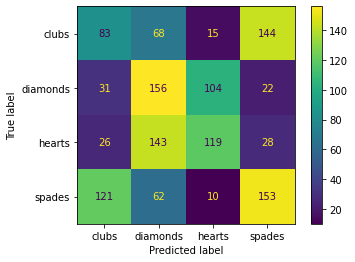

In [243]:
confusion = confusion_matrix(classes_valid_labels_hsv,predict_classes_valid_hsv)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Hog and hsv combined feature 

In [244]:
def extract_hog_hsv_features_from_generator(data_generator):
    hog_features = []
    hsv_features = []
    labels = []
    num_batches = len(data_generator)
    
    for _ in range(num_batches):
        batch_images, class_labels = data_generator.next()  # Get the next batch of augmented images (ignoring the labels)
        
        # Compute hsv features for each image in the batch
        for image, label in zip(batch_images, class_labels):
            hsv_feature = hist_hsv(image).flatten()  
            hsv_features.append(hsv_feature)
            
            label = list(label)
            labels.append(label)
            
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
            gray_image = gray_image.astype(np.uint8)
            hog_feature = hog(gray_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            hog_features.append(hog_feature)
            
    # Apply PCA to both HOG and HSV features
    pca_hog = PCA(n_components=1000)  # You can adjust the number of components as needed
    pca_hsv = PCA(n_components=100)  # You can adjust the number of components as needed
    reduced_hog_features = pca_hog.fit_transform(np.array(hog_features))
    reduced_hsv_features = pca_hsv.fit_transform(np.array(hsv_features))
    
    # Concatenate the reduced HOG and HSV features
    blended_features = np.hstack((reduced_hog_features, reduced_hsv_features))
    
    return blended_features, np.array(labels)

In [245]:
train_hog_hsv_features, train_labels = extract_hog_hsv_features_from_generator(train_generator)
valid_hog_hsv_features, valid_labels = extract_hog_hsv_features_from_generator(valid_generator)
test_hog_hsv_features, test_labels = extract_hog_hsv_features_from_generator(test_generator)

<ipython-input-237-4a36c3c7071f>:13: RuntimeWarning: invalid value encountered in true_divide
  hist_saturation_normalized = (hist_saturation - np.min(hist_saturation)) / (np.max(hist_saturation) - np.min(hist_saturation))
<ipython-input-237-4a36c3c7071f>:12: RuntimeWarning: invalid value encountered in true_divide
  hist_hue_normalized = (hist_hue - np.min(hist_hue)) / (np.max(hist_hue) - np.min(hist_hue))
<ipython-input-237-4a36c3c7071f>:12: RuntimeWarning: invalid value encountered in true_divide
  hist_hue_normalized = (hist_hue - np.min(hist_hue)) / (np.max(hist_hue) - np.min(hist_hue))
<ipython-input-237-4a36c3c7071f>:13: RuntimeWarning: invalid value encountered in true_divide
  hist_saturation_normalized = (hist_saturation - np.min(hist_saturation)) / (np.max(hist_saturation) - np.min(hist_saturation))
<ipython-input-237-4a36c3c7071f>:13: RuntimeWarning: invalid value encountered in true_divide
  hist_saturation_normalized = (hist_saturation - np.min(hist_saturation)) / (np.max

In [246]:
train_hog_hsv_features.shape

(5138, 1100)

In [247]:
num_classes = 4

model_hog_hsv = Sequential()
model_hog_hsv.add(Dense(128, activation='relu', input_shape=(train_hog_hsv_features.shape[1],)))
model_hog_hsv.add(Dropout(0.03))
model_hog_hsv.add(Dense(64, activation='relu'))
model_hog_hsv.add(Dropout(0.03))
model_hog_hsv.add(Dense(num_classes, activation='softmax'))

model_hog_hsv.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [248]:
# Train the CNN model
model_hog_hsv.fit(train_hog_hsv_features, train_labels,
                    batch_size=32,
                    epochs=20,
                    validation_data=(valid_hog_hsv_features, valid_labels))


Epoch 1/20
161/161 [==============================] - 1s 5ms/step - loss: 19.4749 - accuracy: 0.3295 - val_loss: 13.9741 - val_accuracy: 0.3486
Epoch 2/20
161/161 [==============================] - 1s 4ms/step - loss: 12.5251 - accuracy: 0.3787 - val_loss: 11.4414 - val_accuracy: 0.3549
Epoch 3/20
161/161 [==============================] - 1s 4ms/step - loss: 9.9241 - accuracy: 0.4085 - val_loss: 10.3100 - val_accuracy: 0.3634
Epoch 4/20
161/161 [==============================] - 1s 4ms/step - loss: 8.3936 - accuracy: 0.4186 - val_loss: 9.3624 - val_accuracy: 0.3611
Epoch 5/20
161/161 [==============================] - 1s 4ms/step - loss: 7.5048 - accuracy: 0.4404 - val_loss: 8.6587 - val_accuracy: 0.3665
Epoch 6/20
161/161 [==============================] - 1s 4ms/step - loss: 6.4514 - accuracy: 0.4634 - val_loss: 8.2745 - val_accuracy: 0.3603
Epoch 7/20
161/161 [==============================] - 1s 5ms/step - loss: 5.7125 - accuracy: 0.4792 - val_loss: 7.8780 - val_accuracy: 0.3650
E

In [249]:
predict_valid_hog_hsv = model_hog_hsv.predict(valid_hog_hsv_features)
predict_classes_valid_hog_hsv =np.argmax(predict_valid_hog_hsv,axis=1)

classes_valid_labels_hog_hsv = np.argmax(valid_labels,axis=1)

41/41 [==============================] - 0s 2ms/step


In [250]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hog_hsv, predict_classes_valid_hog_hsv)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.32      0.33       310
           1       0.35      0.35      0.35       313
           2       0.33      0.36      0.34       316
           3       0.41      0.40      0.41       346

    accuracy                           0.36      1285
   macro avg       0.36      0.36      0.36      1285
weighted avg       0.36      0.36      0.36      1285



### Sample images

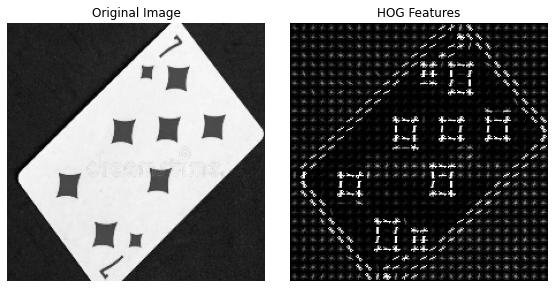

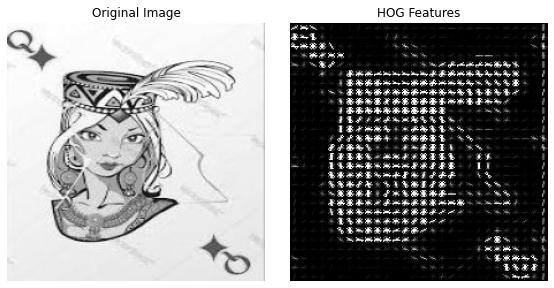

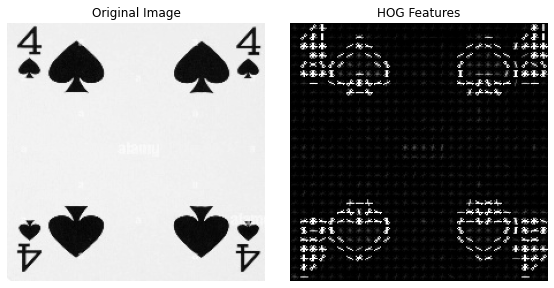

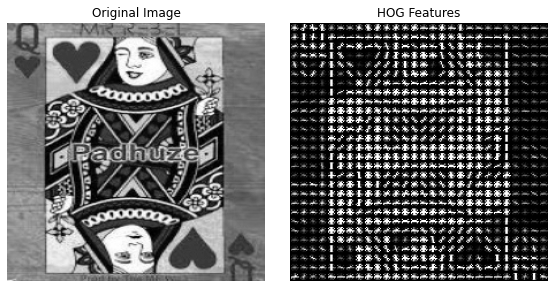

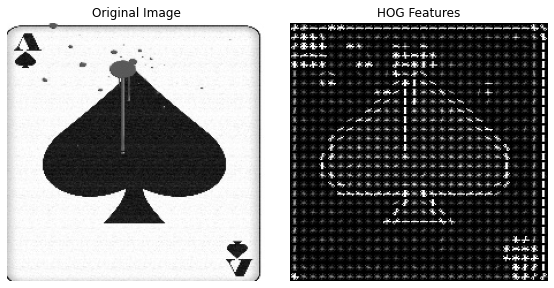

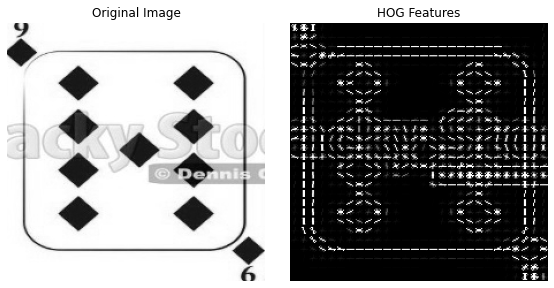

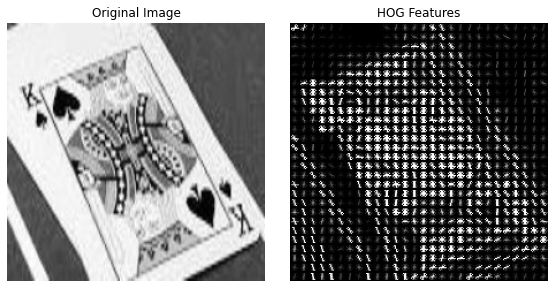

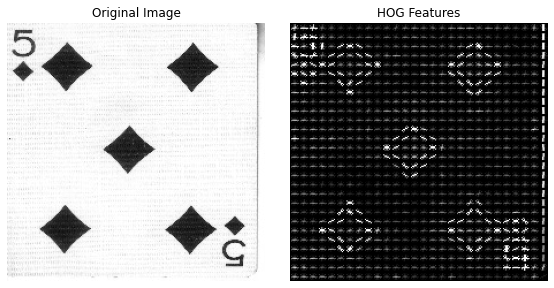

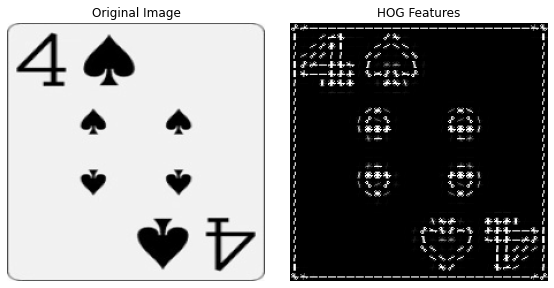

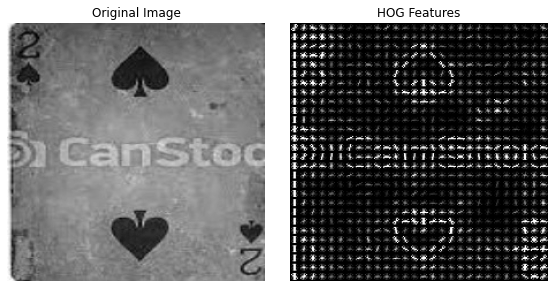

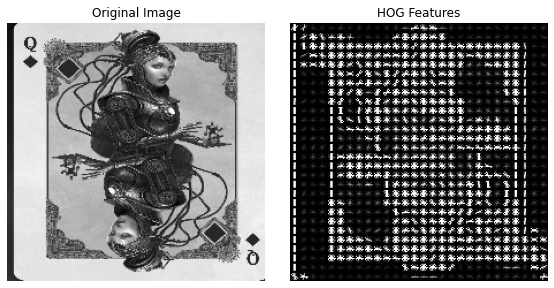

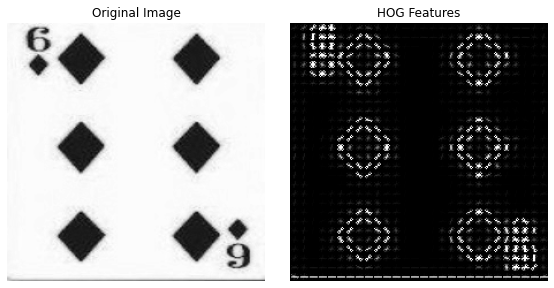

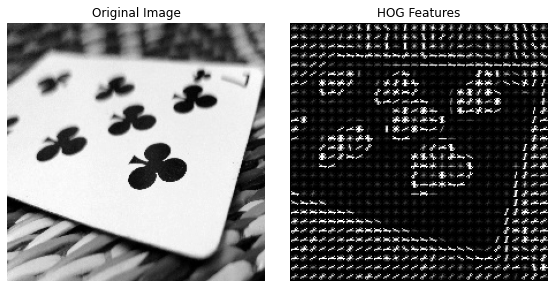

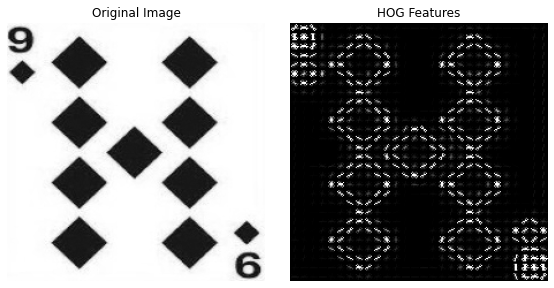

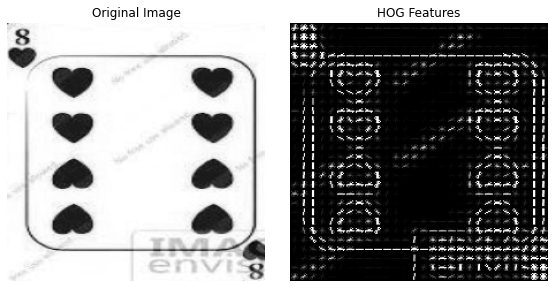

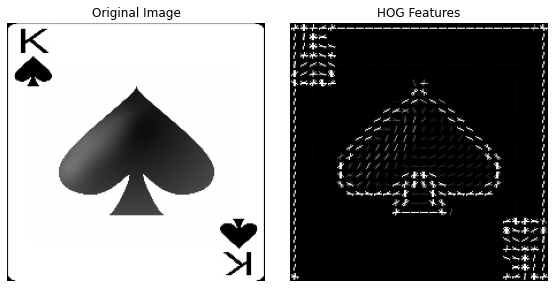

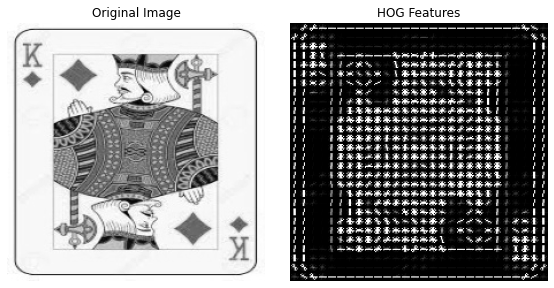

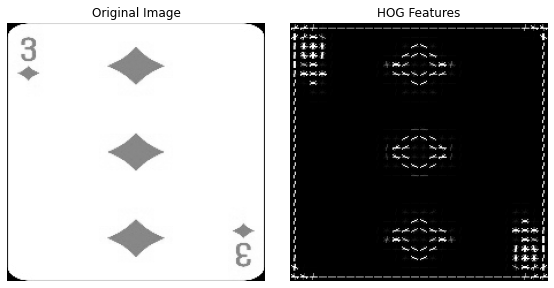

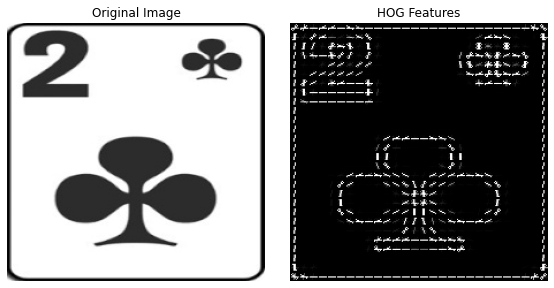

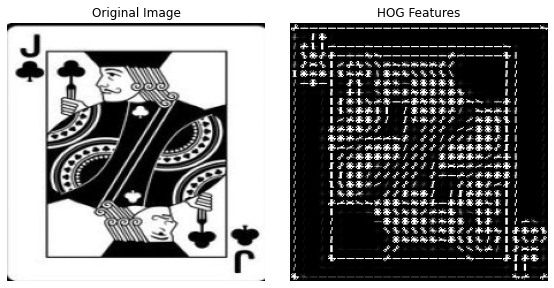

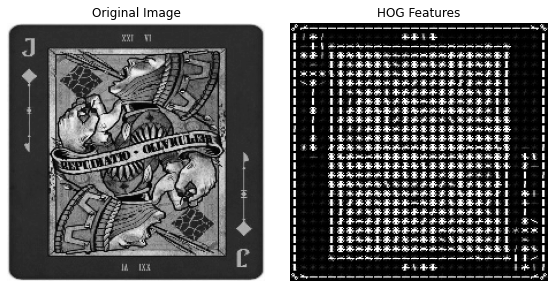

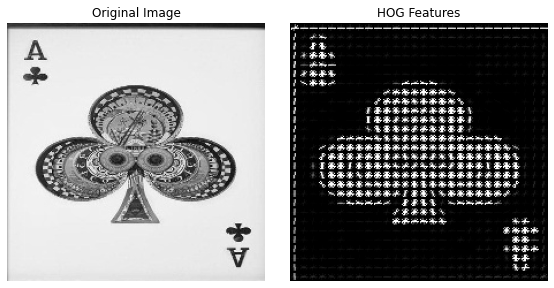

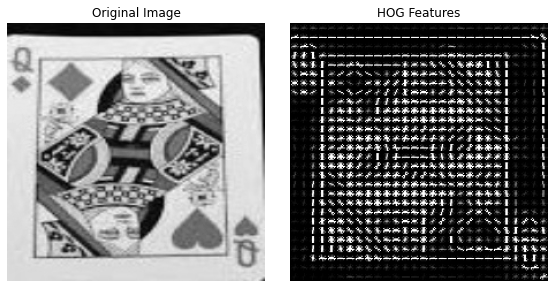

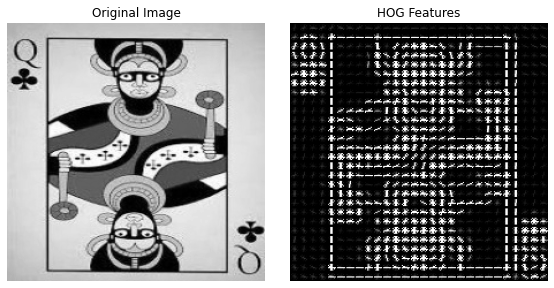

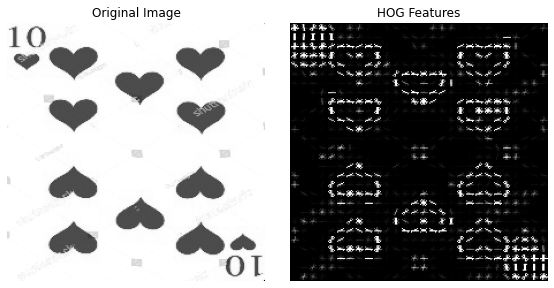

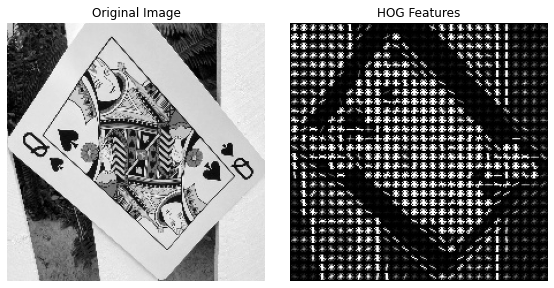

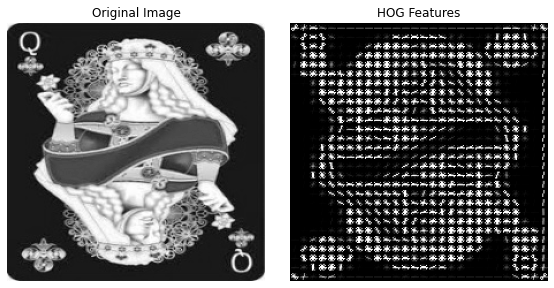

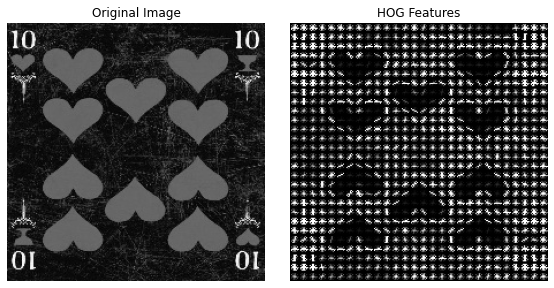

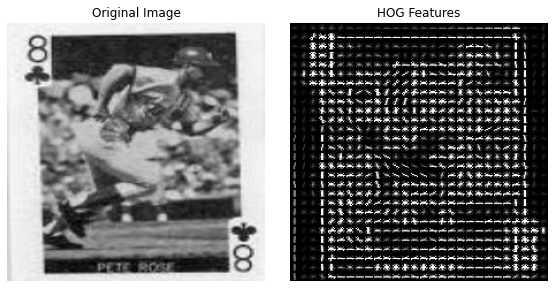

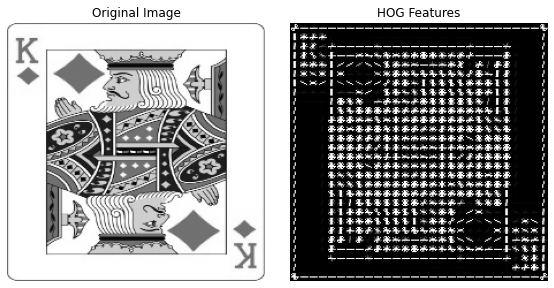

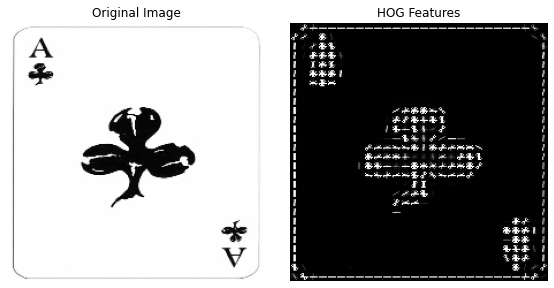

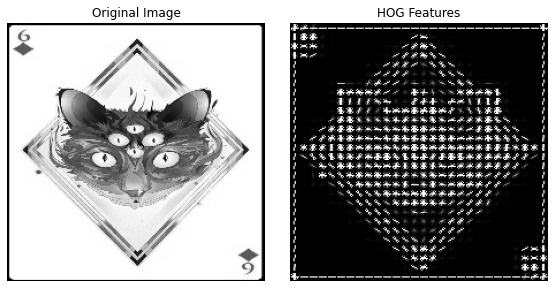

In [251]:

batch_images, class_labels = train_generator.next()  # Get the next batch of augmented images (ignoring the labels)

# Compute hsv features for each image in the batch
for image, label in zip(batch_images,class_labels):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    gray_image = gray_image.astype(np.uint8)
    hog_feature = hog(gray_image, orientations = 8, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(gray_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)[1]
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax[1].imshow(hog_image_rescaled, cmap='gray')
    ax[1].set_title('HOG Features')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()


### hog cnn

In [252]:
def extract_hog_features_from_generator(data_generator):
    hog_features = []
    hsv_features = []
    labels = []
    num_batches = len(data_generator)
    
    for _ in range(num_batches):
        batch_images, class_labels = data_generator.next()  # Get the next batch of augmented images (ignoring the labels)
        
        # Compute hsv features for each image in the batch
        for image, label in zip(batch_images, class_labels):
            #hsv_feature = hist_hsv(image).flatten()  
            #hsv_features.append(hsv_feature)
            
            label = list(label)
            labels.append(label)
            
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
            gray_image = gray_image.astype(np.uint8)
            hog_feature = hog(gray_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            hog_features.append(hog_feature)
    
    # Concatenate the reduced HOG and HSV features
    blended_features = hog_features #np.hstack((reduced_hog_features, reduced_hsv_features))
    
    return np.array(blended_features), np.array(labels)

In [253]:
train_hog_features, train_labels = extract_hog_features_from_generator(train_generator)
valid_hog_features, valid_labels = extract_hog_features_from_generator(valid_generator)
test_hog_features, test_labels = extract_hog_features_from_generator(test_generator)

In [254]:
num_classes = 4

model_hog = Sequential()
model_hog.add(Dense(128, activation='relu', input_shape=(train_hog_features.shape[1],)))
model_hog.add(Dropout(0.03))
model_hog.add(Dense(64, activation='relu'))
model_hog.add(Dropout(0.03))
model_hog.add(Dense(num_classes, activation='softmax'))

model_hog.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [255]:
# Train the CNN model
model_hog.fit(train_hog_features, train_labels,
                    batch_size=32,
                    epochs=20,
                    validation_data=(valid_hog_features, valid_labels))


Epoch 1/20
161/161 [==============================] - 6s 31ms/step - loss: 1.1642 - accuracy: 0.4961 - val_loss: 0.9370 - val_accuracy: 0.6475
Epoch 2/20
161/161 [==============================] - 5s 28ms/step - loss: 0.7846 - accuracy: 0.7246 - val_loss: 0.7276 - val_accuracy: 0.7401
Epoch 3/20
161/161 [==============================] - 5s 28ms/step - loss: 0.5874 - accuracy: 0.7999 - val_loss: 0.6487 - val_accuracy: 0.7463
Epoch 4/20
161/161 [==============================] - 5s 28ms/step - loss: 0.4547 - accuracy: 0.8585 - val_loss: 0.6095 - val_accuracy: 0.7595
Epoch 5/20
161/161 [==============================] - 5s 29ms/step - loss: 0.3578 - accuracy: 0.8941 - val_loss: 0.5742 - val_accuracy: 0.7875
Epoch 6/20
161/161 [==============================] - 5s 29ms/step - loss: 0.2911 - accuracy: 0.9237 - val_loss: 0.6338 - val_accuracy: 0.7494
Epoch 7/20
161/161 [==============================] - 5s 29ms/step - loss: 0.2393 - accuracy: 0.9397 - val_loss: 0.5833 - val_accuracy: 0.7790

In [256]:
predict_valid_hog = model_hog.predict(valid_hog_features)
predict_classes_valid_hog = np.argmax(predict_valid_hog,axis = 1)

classes_valid_labels_hog = np.argmax(valid_labels,axis=1)

41/41 [==============================] - 0s 4ms/step


In [257]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_hog, predict_classes_valid_hog)
print("Validation Classification Report:\n", valid_report)


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       310
           1       0.91      0.73      0.81       313
           2       0.79      0.84      0.82       316
           3       0.75      0.80      0.77       346

    accuracy                           0.80      1285
   macro avg       0.81      0.80      0.80      1285
weighted avg       0.80      0.80      0.80      1285



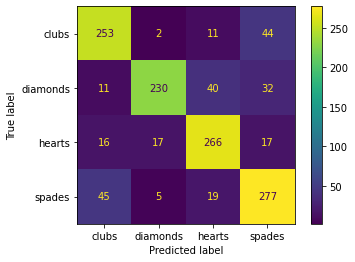

In [258]:
confusion = confusion_matrix(classes_valid_labels_hog,predict_classes_valid_hog)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Predicted value combined

In [259]:
predict_valid_combined = np.hstack((predict_valid_hog,predict_valid_hsv))
predict_classes_valid_combined = np.argmax(predict_valid_combined,axis = 1) % 4

classes_valid_labels_combined = np.argmax(valid_labels,axis=1)

In [260]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_combined, predict_classes_valid_combined)
print("Validation Classification Report:\n", valid_report)


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       310
           1       0.86      0.73      0.79       313
           2       0.78      0.81      0.80       316
           3       0.72      0.79      0.75       346

    accuracy                           0.77      1285
   macro avg       0.78      0.77      0.77      1285
weighted avg       0.78      0.77      0.77      1285



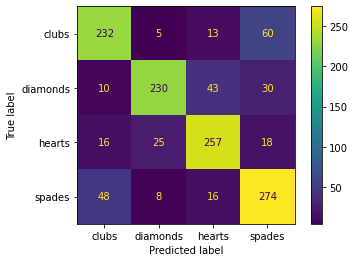

In [261]:
confusion = confusion_matrix(classes_valid_labels_combined,predict_classes_valid_combined)
disp = ConfusionMatrixDisplay(confusion,display_labels = class_names)
disp.plot()

### Try stacking w/ logistic regression

In [262]:
predict_train_hog = model_hog.predict(train_hog_features)
predict_train_hsv = model_hsv.predict(train_hsv_features)

predict_train_combined = np.hstack((predict_train_hog,predict_train_hsv))

classes_train_labels_combined = np.argmax(train_labels,axis=1)

161/161 [==============================] - 0s 1ms/step


In [263]:
from sklearn.linear_model import LogisticRegression


# Create the meta-classifier (Logistic Regression in this case)
meta_classifier = LogisticRegression()

# Train the meta-classifier on the combined predictions and true labels
meta_classifier.fit(predict_train_combined, classes_train_labels_combined)

# Get the final combined prediction using the meta-classifier
final_combined_prediction = meta_classifier.predict(predict_valid_combined)

In [264]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_combined, final_combined_prediction)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       310
           1       0.91      0.73      0.81       313
           2       0.79      0.84      0.82       316
           3       0.75      0.80      0.77       346

    accuracy                           0.80      1285
   macro avg       0.81      0.80      0.80      1285
weighted avg       0.80      0.80      0.80      1285



### Try stacking w/ cnn

In [265]:
num_classes = 4

model_stacked = Sequential()
model_stacked.add(Dense(128, activation='relu', input_shape=(predict_train_combined.shape[1],)))
model_stacked.add(Dropout(0.03))
model_stacked.add(Dense(64, activation='relu'))
model_stacked.add(Dropout(0.03))
model_stacked.add(Dense(num_classes, activation='softmax'))

model_stacked.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [266]:
predict_valid_combined.shape

(1285, 8)

In [267]:
valid_labels.shape

(1285, 4)

In [268]:
# Train the CNN model
model_stacked.fit(predict_train_combined, train_labels,
                    batch_size=16,
                    epochs=20,
                    validation_data=(predict_valid_combined, valid_labels))


Epoch 1/20
322/322 [==============================] - 2s 2ms/step - loss: 0.9490 - accuracy: 0.9443 - val_loss: 0.7841 - val_accuracy: 0.7977
Epoch 2/20
322/322 [==============================] - 1s 2ms/step - loss: 0.2363 - accuracy: 1.0000 - val_loss: 0.6403 - val_accuracy: 0.7961
Epoch 3/20
322/322 [==============================] - 1s 2ms/step - loss: 0.0489 - accuracy: 1.0000 - val_loss: 0.7442 - val_accuracy: 0.7953
Epoch 4/20
322/322 [==============================] - 1s 2ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.8397 - val_accuracy: 0.7961
Epoch 5/20
322/322 [==============================] - 1s 2ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.9192 - val_accuracy: 0.7969
Epoch 6/20
322/322 [==============================] - 1s 2ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.9869 - val_accuracy: 0.7961
Epoch 7/20
322/322 [==============================] - 1s 2ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0461 - val_accuracy: 0.7969
Epoch 

In [269]:
final_combined_prediction_cnn = model_stacked.predict(predict_valid_combined)
final_combined_prediction_cnn = np.argmax(final_combined_prediction_cnn,axis=1)

41/41 [==============================] - 0s 1ms/step


In [270]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(classes_valid_labels_combined, final_combined_prediction_cnn)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79       310
           1       0.90      0.73      0.81       313
           2       0.80      0.84      0.81       316
           3       0.75      0.80      0.77       346

    accuracy                           0.80      1285
   macro avg       0.80      0.80      0.80      1285
weighted avg       0.80      0.80      0.80      1285

